In [5]:
!pip install langdetect
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=172366f7b3553b0de489b78fb7a7035fd4f035ff56257ecc9820bdd58998a1e9
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.3 MB/s eta 0:00:00


In [6]:
# Import necessary libraries
import re

import pandas as pd
import numpy as np
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.language import Language
from langdetect import detect, DetectorFactory, LangDetectException
from spacy.tokens import Doc
from spacy.language import Language

In [7]:
# Load and clean up reviews
df = pd.read_csv("processed_reviews.csv")
df = df[["content", "score", "at", "app_id"]].copy()
df.head()

,content,score,at,app_id
0,Gett van for no reason 😂😂😂,1,2023-09-19 15:05:31,org.telegram.messenger
1,better' than WhatsApp,4,2023-09-19 14:59:30,org.telegram.messenger
2,That was good app for me,5,2023-09-19 14:55:06,org.telegram.messenger
3,Love the app,5,2023-09-19 14:50:18,org.telegram.messenger
4,🕳️🕳️🕳️,1,2023-09-19 14:48:20,org.telegram.messenger


In [8]:
# Load Spacy English model
nlp = spacy.load("en_core_web_sm")

In [9]:
@Language.component("filter_length")
def filter_length(doc):
    # Count the number of word tokens in the document
    word_count = len([token for token in doc if token.is_alpha])

    # Check if the document has more than 1 word
    if word_count > 1:
        return doc
    else:
        # Return an empty Doc if the condition is not met
        return Doc(doc.vocab, words=[])

# Add the component to the pipeline
nlp.add_pipe("filter_length", name="length_filter", first=True)

<function __main__.filter_length(doc)>

In [10]:
@Language.component("filter_emojis")
def filter_emojis(doc):
    # Check if the document is empty (as a result of the previous filter)
    if len(doc) == 0:
        return doc

    # Regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    # Remove emojis from the text
    new_text = emoji_pattern.sub(r'', doc.text)

    # Create a new Doc with the emoji-free text
    return Doc(doc.vocab, words=new_text.split())

# Add the component to the pipeline
nlp.add_pipe("filter_emojis", name="emoji_filter", after="length_filter")

<function __main__.filter_emojis(doc)>

In [11]:
# Set seed for langdetect to get deterministic results
DetectorFactory.seed = 0

@Language.component("filter_language")
def filter_language(doc):
    # Check if the document is empty
    if len(doc) == 0:
        return doc

    try:
        # Detect the language of the text
        if detect(doc.text) == 'en':
            return doc
        else:
            # Return an empty Doc if the text is not English
            return Doc(doc.vocab, words=[])
    except LangDetectException:
        # Handle exception if language detection fails
        return Doc(doc.vocab, words=[])

# Add the component to the pipeline
nlp.add_pipe("filter_language", name="language_filter", after="emoji_filter")

<function __main__.filter_language(doc)>

In [12]:
# Custom component for keeping only standard English sentence symbols
@Language.component("filter_english_symbols")
def filter_english_symbols(doc):
    # Define a regular expression pattern to match all types of punctuation
    punctuation_pattern = re.compile(r'[^\w\s]+')

    # Use re.sub() to replace punctuation with an empty space in the entire text
    processed_text = re.sub(punctuation_pattern, ' ', doc.text)

    # Create a new Doc with the processed text
    new_doc = Doc(doc.vocab, words=processed_text.split())
    return new_doc

# Add the component to the pipeline
nlp.add_pipe("filter_english_symbols", name="english_symbol_filter", after="language_filter")

<function __main__.filter_english_symbols(doc)>

In [13]:
@Language.component("remove_stopwords")
def remove_stopwords(doc):
    # Check if the document is empty
    if len(doc) == 0:
        return doc

    # Remove stop words from the text
    stop_words = set(token.text for token in doc if token.is_stop and token.text.lower() not in {"not", "do", "can","don"})
    filtered_tokens = [token.text for token in doc if token.text not in stop_words]
    # Check if filtered tokens are empty
    if not filtered_tokens:
        return doc

    # Create a new Doc with the text without stop words
    new_doc = Doc(doc.vocab, words=filtered_tokens)
    return new_doc

# Add the component to the pipeline
nlp.add_pipe("remove_stopwords", name="stopword_remover", after="english_symbol_filter")

<function __main__.remove_stopwords(doc)>

In [14]:
contractions = {
    "t": "not",
    "don": "do",
    "doesn": "does",
    "didn": "did",
    "won": "will",
    "cant": "cannot",
}

@Language.component("expand_contractions")
def expand_contractions(doc):
    # Check if the document is empty
    if len(doc) == 0:
        return doc

    # Expand contractions in the text
    expanded_tokens = [contractions.get(token.text, token.text) for token in doc]

    # Check if expanded tokens are empty
    if not expanded_tokens:
        return doc

    # Create a new Doc with the expanded text
    new_doc = Doc(doc.vocab, words=expanded_tokens)
    return new_doc

# Add the component to the pipeline
nlp.add_pipe("expand_contractions", name="contraction_expander", after="stopword_remover")

<function __main__.expand_contractions(doc)>

In [15]:
@Language.component("preprocess_text")
def preprocess_text(doc):
    # Check if the document is empty
    if len(doc) == 0:
        return doc

    # Process the text: lowercase, remove punctuation, and lemmatize
    lemmatized_tokens = [token.lemma_.lower() for token in doc if token.is_alpha]

    if not lemmatized_tokens:
      return doc

    # Create a new Doc with the processed text
    # Note: This method preserves the original Doc's properties
    new_doc = Doc(doc.vocab, words=lemmatized_tokens)
    return new_doc

# Add the component to the pipeline
nlp.add_pipe("preprocess_text", name="text_preprocessor", last=True)
# nlp.remove_pipe("text_preprocessor")

<function __main__.preprocess_text(doc)>

In [19]:
# Save our preprocessing pipeline
nlp.pipe_names
nlp.to_disk("preprocessing_service/pipeline")

In [20]:
# Parse reviews using our pipeline and add them to our dataset
parsed_reviews = []
counter = 0
for i in list(df.index):
  content = df.at[i, "content"]
  parsed = nlp(content)
  if counter < 10:
    print("content:", content)
    print("parsed:", parsed)
    print("#"*10)
  parsed_reviews.append(parsed)
  counter += 1
df["parsedContent"] = parsed_reviews

content: Gett van for no reason 😂😂😂
parsed: 
##########
content: better' than WhatsApp
parsed: well whatsapp 
##########
content: That was good app for me
parsed: good app 
##########
content: Love the app
parsed: love app 
##########
content: 🕳️🕳️🕳️
parsed: 
##########
content: Good app
parsed: good app 
##########
content: Nice app
parsed: nice app 
##########
content: telegram mare call par nai ban rhi
parsed: 
##########
content: now how to mute stories?
parsed: mute story 
##########
content: Good parfom sab 1
parsed: 
##########


In [21]:
# Parsing reviews into usable pieces of text leaves us with half of the reviews
print(df.shape[0])
df_use = df.loc[df["parsedContent"].apply(lambda x: len(x)>1)].copy()
print(df_use.shape[0])

1200
551


In [22]:
# We will now transform it into a format that will be used in training
df_use["sentiment_pos"] = df_use["score"].apply(lambda x: x>3)
df_use['cats'] = [{'POSITIVE': y==True, 'NEGATIVE': y==False} for y in df_use['sentiment_pos']]
df_use[["content", "sentiment_pos"]].head()

,content,sentiment_pos
1,better' than WhatsApp,True
2,That was good app for me,True
3,Love the app,True
5,Good app,True
6,Nice app,True


In [24]:
# We will extend our training dataset using Threads reviews
# https://www.kaggle.com/datasets/jayagopal20/threads-app-reviews-dataset?resource=download
df2 = pd.read_csv("threads_reviews.csv").reset_index(drop=True)
df2["app_id"] = df2["source"].apply(lambda x: "com.instagram.barcelona")
df2["at"] = df2["review_date"]
df2["content"] = df2["review_description"]
df2["score"] = df2["rating"]
df2[["content", "score", "at", "app_id"]].head()

# We will use a random sample of 5000 reviews
df2 = df2.sample(n=5000, random_state=42).copy()

In [25]:
# We will also parse our second dataset
parsed_reviews = []
counter = 0
for i in list(df2.index):
  content = df2.at[i, "content"]
  parsed = nlp(content)
  if counter < 10:
    print("content:", content)
    print("parsed:", parsed)
    print("#"*10)
  parsed_reviews.append(parsed)
  counter += 1
df2["parsedContent"] = parsed_reviews

content: I think you guys also keep sign in by Facebook account brings more user
parsed: think guy sign facebook account bring user 
##########
content: 5 🌟🌟🌟🌟🌟
parsed: 
##########
content: Amazing Application. Thanks team Meta
parsed: amazing application thank team meta 
##########
content: it was great! lovin' d app so far 💘 pero I hope it have like the thing to pin ur post
parsed: great lovin d app far pero hope like thing pin ur post 
##########
content: Good but had a bug it wouldnt let me add photo so had to reinstall
parsed: good bug wouldnt let add photo reinstall 
##########
content: Very interesting and addictive
parsed: interesting addictive 
##########
content: RIP privacy
parsed: rip privacy 
##########
content: It's good
parsed: s good 
##########
content: Wow
parsed: 
##########
content: This is nice app
parsed: nice app 
##########


In [26]:
# Parsing Threads reviews leaves around 60% usable
print(df2.shape[0])
df_use2 = df2.loc[df2["parsedContent"].apply(lambda x: len(x)>1)].copy()
print(df_use2.shape[0])

5000
3204


In [27]:
# We will also make this dataset fit for training
df_use2["sentiment_pos"] = df_use2["score"].apply(lambda x: x>3)
df_use2['cats'] = [{'POSITIVE': y==True, 'NEGATIVE': y==False} for y in df_use2['sentiment_pos']]
df_use2[["content", "sentiment_pos"]].head()

,content,sentiment_pos
13375,I think you guys also keep sign in by Facebook...,True
32221,Amazing Application. Thanks team Meta,True
7686,it was great! lovin' d app so far 💘 pero I hop...,True
16063,Good but had a bug it wouldnt let me add photo...,True
32977,Very interesting and addictive,True


In [28]:
# Randomly sample for a training dataset, use the rest for testing
df_train = df_use.sample(frac=0.33, random_state=42).copy()
df_dev = df_use.drop(df_train.index, inplace=False).sample(frac=0.5, random_state=42).copy()
df_test = df_use.drop(df_train.index).drop(df_dev.index).copy()

# We will extend our training dataset with processed Threads reviews
df_train = pd.concat([
    df_train[["content", "parsedContent", "score", "at", "app_id", "cats", "sentiment_pos"]],
    df_use2[["content", "parsedContent", "score", "at", "app_id", "cats", "sentiment_pos"]]
    ]).reset_index(drop=True).copy()

In [29]:
print(df_train.shape) # Training dataset is quite large
print(df_dev.shape)
print(df_test.shape)

(3386, 7)
(184, 7)
(185, 7)


In [30]:
from spacy.training import Example
from spacy.tokens import DocBin

# Create training, validation and test sets and save them in .spacy format
bin = DocBin()

for i in list(df_train.index):
  example = Example.from_dict(df_train.at[i, "parsedContent"], {'cats': df_train.at[i, 'cats']})
  bin.add(example.reference)

bin.to_disk('train.spacy')

bin = DocBin()

for i in list(df_dev.index):
  example = Example.from_dict(df_dev.at[i, "parsedContent"], {'cats': df_dev.at[i, 'cats']})
  bin.add(example.reference)

bin.to_disk('dev.spacy')

bin = DocBin()

for i in list(df_test.index):
  example = Example.from_dict(df_test.at[i, "parsedContent"], {'cats': df_test.at[i, 'cats']})
  bin.add(example.reference)

bin.to_disk('test.spacy')

In [31]:
# create a configuration file with default settings
!python -m spacy init config -p textcat config.cfg

2024-01-25 19:11:06.407573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 19:11:06.407636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 19:11:06.409043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 19:11:07.723851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- 

In [32]:
# train the model
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy

2024-01-25 19:11:17.899805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 19:11:17.899880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 19:11:17.901160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 19:11:19.218873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline ======

In [33]:
# test the saved model
nlp = spacy.load("output/model-best")

In [34]:
# evaluate on the first 5 reviews
for i in list(df_test.index)[:5]:
  content = df_test.at[i, "parsedContent"]
  positive_sentiment = df_test.at[i, "sentiment_pos"]
  print("First 5 words:", content[:5], "predicted positive probability:", round(nlp(content).cats["POSITIVE"], 2), "true positive sentiment:", positive_sentiment)

First 5 words: good app predicted positive probability: 0.71 true positive sentiment: True
First 5 words: nice app predicted positive probability: 0.7 true positive sentiment: True
First 5 words: barr user login tangible reason predicted positive probability: 0.31 true positive sentiment: False
First 5 words: good study predicted positive probability: 0.66 true positive sentiment: True
First 5 words: hein soe predicted positive probability: 0.51 true positive sentiment: False


In [35]:
positive_class = []
for i in list(df_test.index):
  content = df_test.at[i, "parsedContent"]
  positive_class.append(nlp(content).cats["POSITIVE"])
df_test["sentiment_pos_pred"] = positive_class

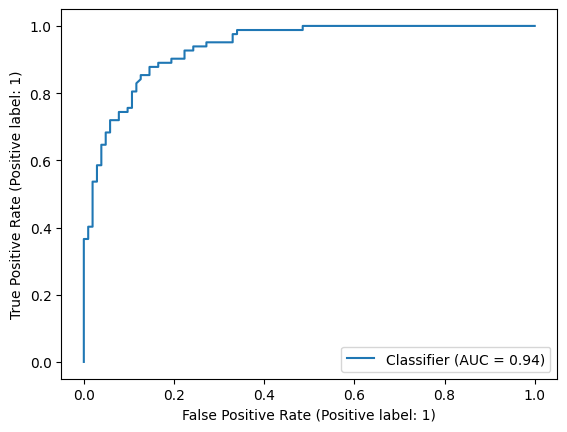

In [36]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(
    df_test["sentiment_pos"],
    df_test["sentiment_pos_pred"]
)

In [37]:
predicted_class = []
for i in list(df_test.index):
  content = df_test.at[i, "parsedContent"]
  positive = nlp(content).cats["POSITIVE"]
  negative = nlp(content).cats["NEGATIVE"]
  predicted_class.append(0 if negative > positive else 1)
df_test["sentiment_pred"] = predicted_class

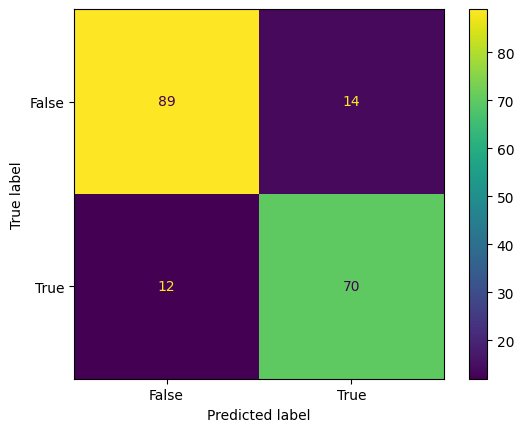

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    df_test["sentiment_pos"],
    df_test["sentiment_pred"]
)